# Bayesian Inference Statistics in A/B Testing

Controlled experiments and data analytics became a major driving force behind data-driven business decisions in recent years. *A/B-Testing* is one of the most common experiments to see, if a given treatment is more accepted in the treatment group than the non-treatment in the control group. 
Or in plain English: **if I change this yellow button to blue, will my customers be more likely to click it?**

In this experiment I want to explore how Bayesian inference statistics can help making data-driven business decisions and where and why this approach has its short-comings.
The data in this experiment is fictional data from a marketing campaign done by Random Company, Inc. and for illustration purposes only.

This document can be found here on my <a href="https://github.com/MaxWhyte/BA_Thesis_Statistics" target="_blank">GitHub</a>.

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

## The experiment
In your company, the smart guys from the Web Design department build a banner with a new feature X for the company website that should increase the clickrate instead of feature Y that was used until today. The CEO wants us to check: 
1. How likely is it that the new feature will perform better in the future?
2. Which gain can he expect in the future? 
3. If things won't work out, how much loss should he expect?

To test the performance of feature X against feature Y we show the website with the new feature X to 50% of all website visitors and to 50% of them the website with the old feature Y. So every second user gets to see feature X. The goal is to see if and how many users click on the banner with feature X compared to the old banner with feature Y. After a full week we stop the experiment and look at the numbers. Depending on the results, the CEO will decide if feature X is performing good enough to replace the old feature Y.

### The Prior belief - what we know and what we don't know
We know nothing about the new website yet, but the head of marketing tells us that other campaigns in the past yielded a click rate of about 15-16%.

Here comes the math:
Now, having a good guess about the prior distribution of about 15-16% for similar campaigns, we can use that limited knowledge to find a fitting beta distribution for said 15-16%. Let's start building our model.
To get that percentage as an average, we assume a distribution of 10 clicks out of 60 users that get sent to the new website: 10/60 = 16.6% which is close enough to 15-16%.
Looks like a beta of 10/50 fits the prior belief of 15%.

Here alpha is the number of successes (a user clicks on the banner), beta the number of fails (a user does not click on the banner). With Numpy we can generate 100.000 fitting prior draws from a Beta distribution with those alpha and beta parameters.

In [162]:
alpha = 10
beta = 50
prior_draws = np.random.beta(alpha, beta, 100000)

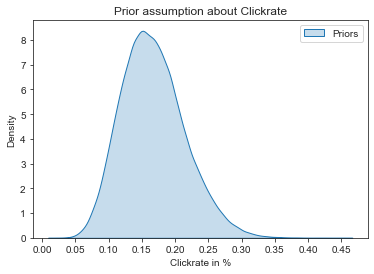

In [168]:
# Plot the prior
plt.title("Prior assumption about Clickrate")
sns.kdeplot(prior_draws, shade=True, label="Priors")
plt.legend()
plt.xlabel("Clickrate in %")
plt.xticks(np.arange(0, max(prior_draws), 0.05))
plt.show()

After plotting these draws we can see that they pretty much match the 15-16% foreseen by the wise Head of marketing. The distribution spikes at about 15%. Less likely but still possible click rates of 5 to 35% can also be seen. This is our best guess about the future performance of feature 
 
 ### The Likelihood - having a look at the actual user behaviour
 
After running the A/B Test for some time, we collected data from 10.000 users. 50% were sent to the old website with feature X, 50% were sent to the new version showing feature Y.
Time to load the actual data that we gathered from the test. All we need from the data is column "site_version" and column "banner_clicked" which tells us if a user clicked on the banner (indicated by a 1) or not (indicated by a 0. With `ads.head(5)` we get a to peek at the first few rows of our data frame.

In [347]:
ads = pd.read_csv("ads.csv", sep=";")
ads.head(5)

,user_id,site_version,time,banner_clicked
0,f500b9f27ac611426935de6f7a52b71f,X,28.01.2019 16:47,0
1,cb4347c030a063c63a555a354984562f,Y,31.03.2019 17:34,0
2,89cec38a654319548af585f4c1c76b51,X,06.02.2019 09:22,0
3,1d4ea406d45686bdbb49476576a1a985,X,23.05.2019 08:07,0
4,d14b9468a1f9a405fa801a64920367fe,X,28.01.2019 08:16,0


In [219]:
# Data Cleaning
x_clicked = ads.loc[ads["site_version"] == "X"]["banner_clicked"] # Extracts the banner_clicked column for each site_version
y_clicked = ads.loc[ads["site_version"] == "Y"]["banner_clicked"]

### The Posterior Distribution

To get the posterior distribution - our final best guess about the probabilities in our experiment - we draw another 100.000 times from a beta distribution. But this time the distribution consists of our prior assumptions AND the actual numbers from data we collected during the A/B Test.

In [220]:
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b):
    ###
    ### Generates posterior distribution from likelihood and priors (actual data and prior assumption)
    ###
    num_successes = np.sum(trials)   
    posterior_draws = np.random.beta(num_successes + beta_prior_a,len(trials) - num_successes + beta_prior_b, 100000)
    
    return posterior_draws

In [221]:
# Simulate posterior draws
x_posterior = simulate_beta_posterior(x_clicked, alpha, beta)
y_posterior = simulate_beta_posterior(y_clicked, alpha, beta)

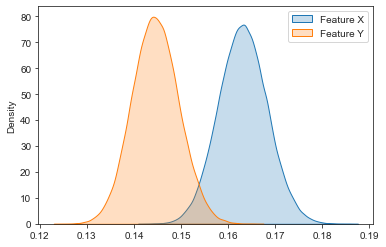

In [223]:
sns.kdeplot(x_posterior, shade=True, label="Feature X")
sns.kdeplot(y_posterior, shade=True, label="Feature Y")
plt.legend()
plt.show()

It looks like Feature X with a click rate of about 16-17% performs better than Feature Y with 14-15%. That's good to see that there is an increase in click rates after we put the new feature Y online. 

### But how much better is it really? 

At first, We just look at the difference between both performances.

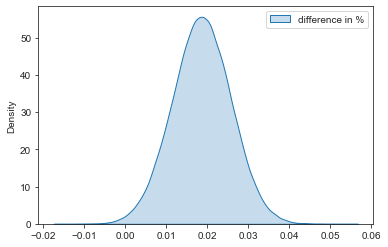

In [272]:
diff = x_posterior - y_posterior # Calculates posterior difference and plots it
sns.kdeplot(diff, shade=True, label="difference in %")
plt.legend()
plt.show()

**Looks like on average feature X is almost 2% better performing.**

We cannot be 100% sure about feature X also being better in the future or in similar campaigns. But, with regards to the data that we have right now, how sure can we be? Being 95% sure is enough for most business cases, that's why a 95% credible interval is industry standard and we intend to follow the masses. The credible interval shows the region where the highest posteriors have the highest density. That's the spot where the good stuff is. 

In [270]:
interval = pm.hpd(diff, hdi_prob=0.95) # Calculates and prints xx% credible interval with the highest posterior density of posterior difference
print(interval)

[0.00421331 0.03242865]


The credible interval tells us that feature X is with a 95% probability between 0.4% and 3.2% better.

Let's try to play it safe: how likely is it that the new feature X performs better, even by the slightest bit?

In [254]:
x_better_prob = (diff > 0).mean() # Calculates the average of better performing draws
print(x_better_prob)

0.9951


So **feature X is very likely better with a certainty of 99.51%.**

But what about the 0.49%? Out of 200 campaigns one would fail. Will it result in a total disaster? Let's try some risk management and look at the expected loss, just in case feature X is not performing better.

In [255]:
loss = diff[diff < 0] # Slice diff to take only cases where it is negative
expected_loss = loss.mean() # Compute and print the average expected loss
print(expected_loss)

-0.0026597132232852763


**With 0.49% probability we get worse results with the new campaign.** But in those cases **the loss is on average only 0.26%.** That doesn't look too bad.
Let's see how the loss is distributed.

In [258]:
interval_loss = pm.hpd(loss, hdi_prob=0.95) # Calculate and print xx% credible interval of highest posterior density
print(interval_loss)

[-0.00696912 -0.00037735]


In those 0.49% cases where feature X is performing worse than feature Y we will see - with a probability of 95% - an expected loss between 0.03 and 0.69%. Considering it is much less likely to see the campaign fail, the expected loss is much less than what we can gain in case the campaign performs well.

### The verdict
Overall feature X looks very promising and you can tell the CEO that **the company definitely should use feature X to increase the clickrates.**

----
In case the CEO is a bit more tech-savvy, we can use the code below that shows you the distribution, mean, HDI and ranges in one plot. There we have the same information but in a compressed way.

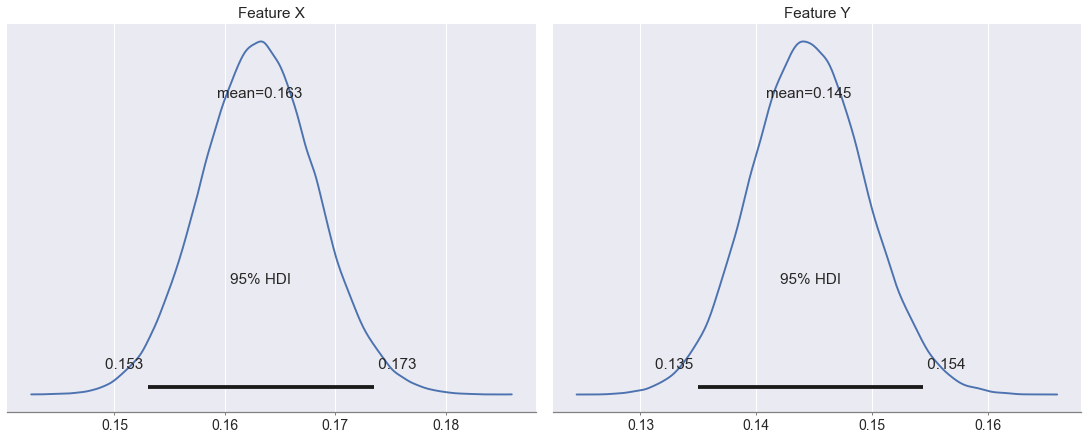

In [346]:
# Plotting the distribution, mean, HDI and ranges in one plot
clickrate = {
    "Feature X": x_posterior,
    "Feature Y": y_posterior,
}

pm.plot_posterior(clickrate, hdi_prob=0.95, textsize=14, figsize=(15,6), round_to=3, point_estimate='mean')
plt.show()

Further outlook & things to consider:
* Bayes vs Frequentist approach: which one is better at point estimating and in explaining the results?
* Multiarmed Bandit: how can one speed the experiment up?